In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import catboost as cb
import lightgbm as lgb

d:\anaconda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = pd.read_csv("../data/processed/train_data.csv").drop("Disease", axis=1)
y_train = pd.read_csv("../data/processed/train_data.csv")["Disease"]
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

In [3]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))
rf_model = RandomForestClassifier(random_state=42)
svm_pipe = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=42))
nb_model = GaussianNB()
catboost_model = cb.CatBoostClassifier(verbose=0, random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)

In [4]:
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_pipe),
    ('rf', rf_model),
    ('svm', svm_pipe),
    ('nb', nb_model),
    ('catboost', catboost_model),
    ('lgb', lgb_model)
], voting='soft')

In [5]:
param_grid = {
    'lr__logisticregression__C': [0.1, 1, 10],
    'rf__n_estimators': [100, 200],
    'svm__svc__C': [0.1, 1, 10],
    'catboost__iterations': [300, 500],
    'lgb__learning_rate': [0.01, 0.1],
}

In [6]:
grid_search = GridSearchCV(voting_clf, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 13
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[L

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler()),
                                                                     ('logisticregression',
                                                                      LogisticRegression(random_state=42,
                                                                                         solver='liblinear'))])),
                                                    ('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('svm',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler()),
                                                                     ('svc',
                                                                      SVC(kernel='linear',
                                                                          probability=True,
                                                                          rand...
                                                    ('nb', GaussianNB()),
                                                    ('catboost',
                                                     <catboost.core.CatBoostClassifier object at 0x00000273BBB1B9A0>),
                                                    ('lgb',
                                                     LGBMClassifier(random_state=42))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'catboost__iterations': [300, 500],
                         'lgb__learning_rate': [0.01, 0.1],
                         'lr__logisticregression__C': [0.1, 1, 10],
                         'rf__n_estimators': [100, 200],
                         'svm__svc__C': [0.1, 1, 10]},
             scoring='accuracy')

In [7]:
best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'catboost__iterations': 300, 'lgb__learning_rate': 0.1, 'lr__logisticregression__C': 1, 'rf__n_estimators': 100, 'svm__svc__C': 0.1}


In [8]:
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=5)
print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 12
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.776585
[LightGBM] [Info] Start training from score -3.622434
[LightGBM] [

In [9]:
y_pred = best_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9016
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
     

d:\anaconda\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


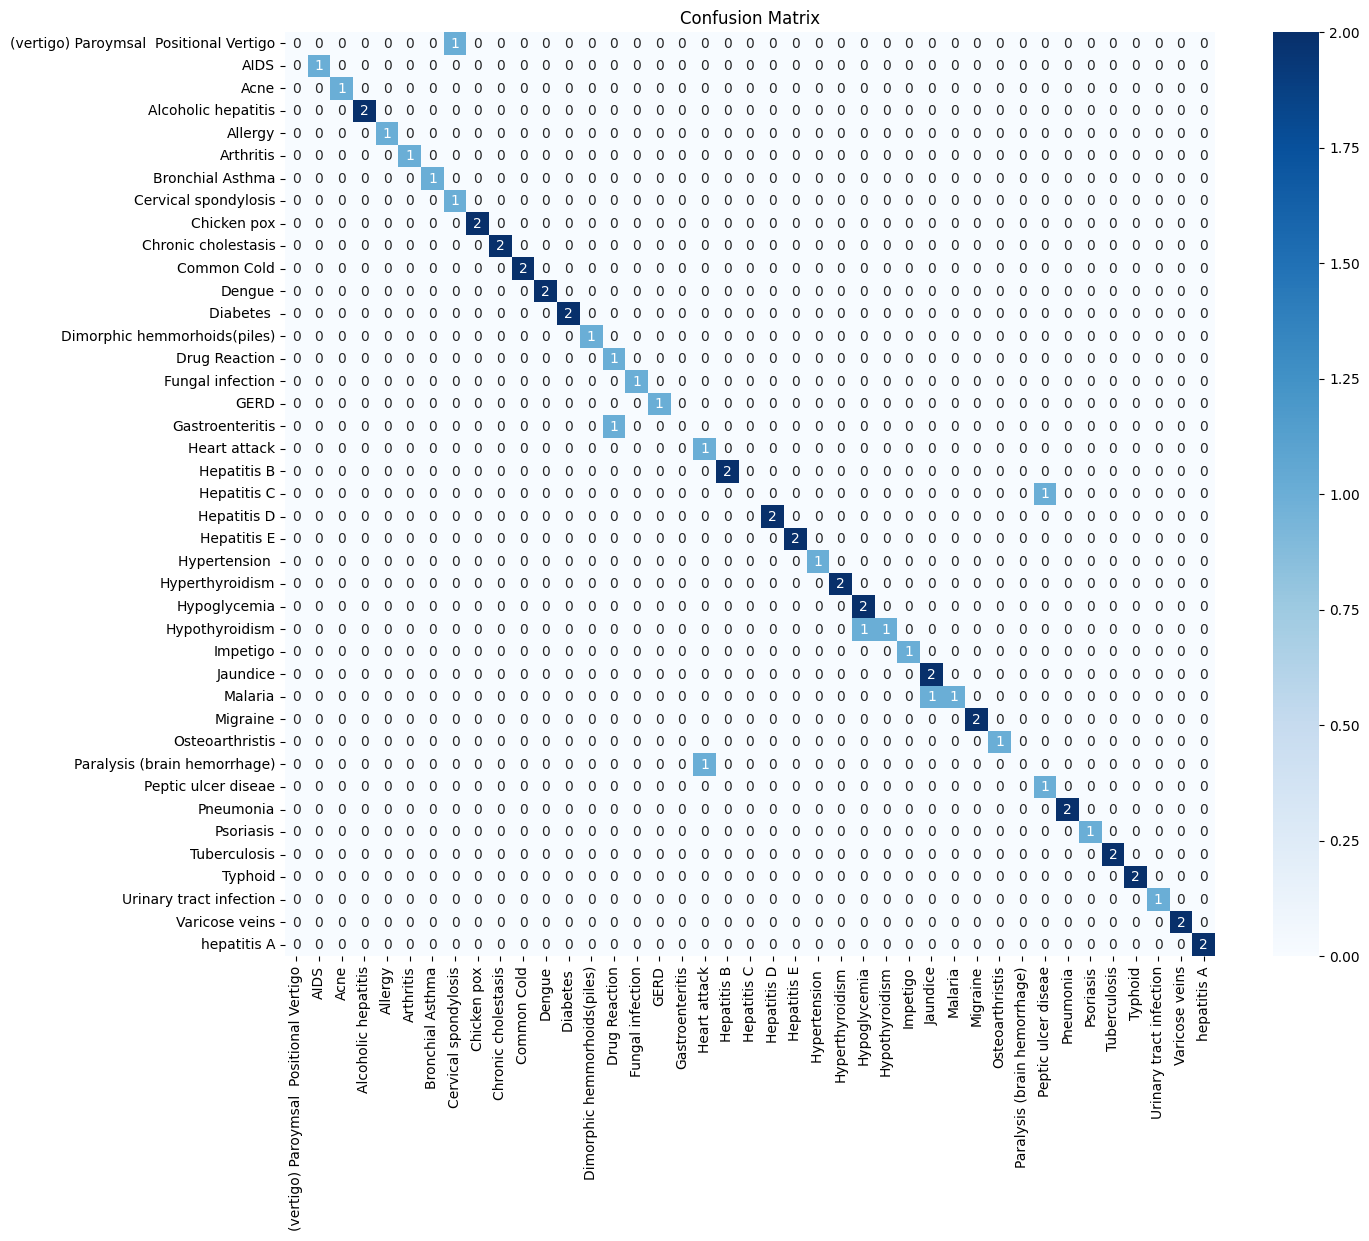

In [10]:
disease_encoder = joblib.load("../src/models/disease_encoder.joblib")
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_encoder.classes_, yticklabels=disease_encoder.classes_)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
d:\anaconda\envs\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/61 [00:00<?, ?it/s]d:\anaconda\e

IndexError: index 22 is out of bounds for axis 1 with size 17

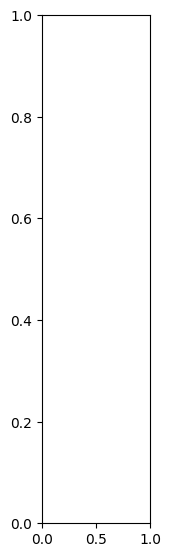

In [ ]:
# explainer = shap.KernelExplainer(best_clf.predict_proba, X_train.sample(50, random_state=42))
# shap_values = explainer.shap_values(X_test)

# # Plot summary
# shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

In [14]:
joblib.dump(best_clf, "../src/models/disease_predictor_v1.joblib")


['../src/models/disease_predictor_v1.joblib']